![Manim Tutorial Logo](images/logo.png)

<center>
    Olivier Leblanc and <href="https://eertmans.be/manim-tutorial">Jérome Eertmans</href><br>
    IEEE Student Branch, October 18th 2022
</center>

In [28]:
import numpy as np
from IPython.display import display, HTML, Markdown as MD
from manim import *


config.media_width = "100%"
config.verbosity = "WARNING"
config.progress_bar = "none"
# config.disable_caching = False
# config.format = "mp4"
# config.quality = "low_quality"
# config.frame_rate = 30

In [2]:
%%manim ManimShowcase

# Present examples are all taken from Manim Community Example Gallery
# and from First Steps with Manim.ipynb


class ContinuousMotion(Scene):
    def construct(self):
        func = lambda pos: np.sin(pos[0] / 2) * UR + np.cos(pos[1] / 2) * LEFT
        stream_lines = StreamLines(func, stroke_width=2, max_anchors_per_line=30)
        self.add(stream_lines)
        stream_lines.start_animation(warm_up=False, flow_speed=1.5)
        self.wait(stream_lines.virtual_time / stream_lines.flow_speed)


class FollowingGraphCamera(MovingCameraScene):
    def construct(self):
        self.camera.frame.save_state()

        # create the axes and the curve
        ax = Axes(x_range=[-1, 10], y_range=[-1, 10])
        graph = ax.plot(lambda x: np.sin(x), color=BLUE, x_range=[0, 3 * PI])

        # create dots based on the graph
        moving_dot = Dot(ax.i2gp(graph.t_min, graph), color=ORANGE)
        dot_1 = Dot(ax.i2gp(graph.t_min, graph))
        dot_2 = Dot(ax.i2gp(graph.t_max, graph))

        self.add(ax, graph, dot_1, dot_2, moving_dot)
        self.play(self.camera.frame.animate.scale(0.5).move_to(moving_dot))

        def update_curve(mob):
            mob.move_to(moving_dot.get_center())

        self.camera.frame.add_updater(update_curve)
        self.play(MoveAlongPath(moving_dot, graph, rate_func=linear))
        self.camera.frame.remove_updater(update_curve)

        self.play(Restore(self.camera.frame))


class MovingAngle(Scene):
    def construct(self):
        rotation_center = LEFT

        theta_tracker = ValueTracker(110)
        line1 = Line(LEFT, RIGHT)
        line_moving = Line(LEFT, RIGHT)
        line_ref = line_moving.copy()
        line_moving.rotate(
            theta_tracker.get_value() * DEGREES, about_point=rotation_center
        )
        a = Angle(line1, line_moving, radius=0.5, other_angle=False)
        tex = MathTex(r"\theta").move_to(
            Angle(
                line1, line_moving, radius=0.5 + 3 * SMALL_BUFF, other_angle=False
            ).point_from_proportion(0.5)
        )

        self.add(line1, line_moving, a, tex)
        self.wait()

        line_moving.add_updater(
            lambda x: x.become(line_ref.copy()).rotate(
                theta_tracker.get_value() * DEGREES, about_point=rotation_center
            )
        )

        a.add_updater(
            lambda x: x.become(Angle(line1, line_moving, radius=0.5, other_angle=False))
        )
        tex.add_updater(
            lambda x: x.move_to(
                Angle(
                    line1, line_moving, radius=0.5 + 3 * SMALL_BUFF, other_angle=False
                ).point_from_proportion(0.5)
            )
        )

        self.play(theta_tracker.animate.set_value(40))
        self.play(theta_tracker.animate.increment_value(140))
        self.play(tex.animate.set_color(RED), run_time=0.5)
        self.play(theta_tracker.animate.set_value(350))


class PlotExample(Scene):
    def construct(self):
        plot_axes = Axes(
            x_range=[0, 1, 0.05],
            y_range=[0, 1, 0.05],
            x_length=9,
            y_length=5.5,
            axis_config={
                "numbers_to_include": np.arange(0, 1 + 0.1, 0.1),
                "font_size": 24,
            },
            tips=False,
        )

        y_label = plot_axes.get_y_axis_label("y", edge=LEFT, direction=LEFT, buff=0.4)
        x_label = plot_axes.get_x_axis_label("x")
        plot_labels = VGroup(x_label, y_label)

        plots = VGroup()
        for n in np.arange(1, 20 + 0.5, 0.5):
            plots += plot_axes.plot(lambda x: x**n, color=WHITE)
            plots += plot_axes.plot(
                lambda x: x ** (1 / n), color=WHITE, use_smoothing=False
            )

        extras = VGroup()
        extras += plot_axes.get_horizontal_line(plot_axes.c2p(1, 1, 0), color=BLUE)
        extras += plot_axes.get_vertical_line(plot_axes.c2p(1, 1, 0), color=BLUE)
        extras += Dot(point=plot_axes.c2p(1, 1, 0), color=YELLOW)
        title = Title(
            r"Graphs of $y=x^{\frac{1}{n}}$ and $y=x^n (n=1, 1.5, 2, 2.5, 3, \dots, 20)$",
            include_underline=False,
            font_size=40,
        )

        self.play(Write(title))
        self.play(Create(plot_axes), Create(plot_labels), Create(extras))
        self.play(AnimationGroup(*[Create(plot) for plot in plots], lag_ratio=0.05))


class PolygonOnAxes(Scene):
    def get_rectangle_corners(self, bottom_left, top_right):
        return [
            (top_right[0], top_right[1]),
            (bottom_left[0], top_right[1]),
            (bottom_left[0], bottom_left[0]),
            (top_right[0], bottom_left[0]),
        ]

    def construct(self):
        ax = Axes(
            x_range=[0, 10],
            y_range=[0, 10],
            x_length=6,
            y_length=6,
            axis_config={"include_tip": False},
        )

        t = ValueTracker(5)
        k = 25

        graph = ax.plot(
            lambda x: k / x,
            color=YELLOW_D,
            x_range=[k / 10, 10.0, 0.01],
            use_smoothing=False,
        )

        def get_rectangle():
            polygon = Polygon(
                *[
                    ax.c2p(*i)
                    for i in self.get_rectangle_corners(
                        (0, 0), (t.get_value(), k / t.get_value())
                    )
                ]
            )
            polygon.stroke_width = 1
            polygon.set_fill(BLUE, opacity=0.5)
            polygon.set_stroke(YELLOW_B)
            return polygon

        polygon = always_redraw(get_rectangle)

        dot = Dot()
        dot.add_updater(lambda x: x.move_to(ax.c2p(t.get_value(), k / t.get_value())))
        dot.set_z_index(10)

        self.add(ax, graph, dot)
        self.play(Create(polygon))
        self.play(t.animate.set_value(10))
        self.play(t.animate.set_value(k / 10))
        self.play(t.animate.set_value(5))


import networkx as nx

nxgraph = nx.erdos_renyi_graph(14, 0.5)


class ErdosRenyiGraph(Scene):
    def construct(self):
        G = Graph.from_networkx(nxgraph, layout="spring", layout_scale=3.5)
        self.play(Create(G))
        self.play(
            *[
                G[v].animate.move_to(
                    5 * RIGHT * np.cos(ind / 7 * PI) + 3 * UP * np.sin(ind / 7 * PI)
                )
                for ind, v in enumerate(G.vertices)
            ]
        )
        self.play(Uncreate(G))


class ThisWasManim(Scene):
    def construct(self):
        title = Tex(r"This scene was created")
        basel = Tex(r"with Manim")
        group = VGroup(title, basel).arrange(DOWN)
        self.play(Write(title), run_time=1.5)
        self.play(
            FadeIn(basel, shift=DOWN),
        )
        self.wait()

        banner_large = ManimBanner(dark_theme=True).scale(1)
        self.play(FadeOut(group), banner_large.create())
        self.play(banner_large.expand())
        self.wait(5)


import functools


def concatenate(*scenes, wait_between_scenes=0, clear_between_scenes=True, audio=None):
    def construct(self):
        if audio:
            self.add_sound(audio)
        for scene in self.scenes:
            scene.construct(self)

            scene.wait(self, wait_between_scenes)

            if clear_between_scenes:

                scene.clear(self)

    def wrapper(cls):
        @functools.wraps(cls)
        def __wrapper__(cls):
            if len(scenes) > 1:
                cls.__bases__ = scenes

            cls.scenes = cls.__bases__
            cls.construct = construct

            return cls

        return __wrapper__(cls)

    if len(scenes) == 1:
        return wrapper(scenes[0])

    return wrapper


@concatenate(audio="audio/showcase.mp3")
class ManimShowcase(
    FollowingGraphCamera,
    PlotExample,
    MovingAngle,
    PolygonOnAxes,
    ErdosRenyiGraph,
    ContinuousMotion,
    ThisWasManim,
):
    pass

display(
    HTML(
        '<center>Song: <i><a href="https://www.youtube.com/watch?v=eBasS6PqbMc&ab_channel=Savfk-Music">"Savfk - Instructions For Living A Life"</a></i>, under a Creative Commons (CC BY 4.0) license.</center>'
    )
)

# Table of Content

1. What is Manim?
2. Manim vs ManimGL
3. How and when to use use Manim
4. Various plugins

# Forewords

Slides, code and documentation are available in open source. See last slide.

# 1. What is Manim?

![Grant Sanderson](images/grant.png)

<center>
    <img alt="3Blue1Brown logo" src="images/3B1B_logo.png" width="500px">
</center>

![3Blue1Brown channel](images/3B1B_channel.png)

# 1. What is Manim?

To quote 3Blue1Brown:

> Manim is an engine for precise programmatic animations, designed for creating explanatory math videos.

Our definition:

> Manim is a Python tool that facilitates creating math-related videos.

## Did you just say Python?

"*I don't know anything about Python*"
* One of the easiest programming languages to learn
* Many examples to learn from

"*I don't like programming*"
* Creating animation requires very basic programming knowledge

"*I usually run into troubles when installing Python modules*"
* Manim works on Windows, macOS, and Linux. Its installation is relatively easy and well documented

### Manim's ABC

### A. Create a file with scene(s)

```python
# scenes.py
from manim import *

class SquareToCircle(Scene):
    def construct(self):
        circle = Circle(color=RED)
        square = Square()     

        self.play(Create(square))
        self.play(Transform(square, circle))
        self.play(FadeOut(square))
```

<br>

### B. Render the scene(s)

```bash
manim scenes.py SquareToCircle
```

<br>

### C. Watch the video!

In [27]:
%%manim SquareToCircle


class SquareToCircle(Scene):
    def construct(self):
        circle = Circle(color=RED)
        square = Square()

        self.play(Create(square))
        self.play(Transform(square, circle))
        self.play(FadeOut(square))

## Motivation

In a few lines of code, Manim can create nice and precise animations, facilitating scientific communication.

* If a picture is worth a thousand words, what about a video?
* Not limited to pure mathematics

## Motivation: example

How to explain the Netwon-Raphson iteration scheme, used to find a root some function $f$?

$$ x_{k+1} = x_{k} - \frac{f(x_k)}{f'(x_k)} $$

In [18]:
%%manim RootExample


class RootExample(Scene):
    def construct(self):
        ax = Axes(
            x_range=[0, 10], y_range=[-30, 100, 10], axis_config={"include_tip": False}
        )
        labels = ax.get_axis_labels(x_label="x", y_label="f(x)")

        def f(x):
            return -2 * (x - 5) ** 3 + 10

        def df(x):
            return -6 * (x - 5) ** 2

        def fdx(x):
            return -f(x) / df(x)

        graph = ax.plot(f, color=MAROON)

        x = 2
        t = ValueTracker(x)

        initial_point = [ax.coords_to_point(x, f(x))]
        dot = Dot(point=initial_point)

        fraction = always_redraw(
            lambda: VGroup(
                MathTex(
                    r"\Delta x = -\frac{f(x)}{f'(x)}=-\frac{"
                    + f"{f(t.get_value()):.2f}"
                    + r"}{"
                    + f"{df(t.get_value()):.2f}"
                    + r"}="
                ),
                MathTex(f"{fdx(t.get_value()):.2f}"),
            )
            .arrange(RIGHT)
            .to_corner(UR)
        )

        dot.add_updater(lambda x: x.move_to(ax.c2p(t.get_value(), f(t.get_value()))))

        self.add(ax, labels, graph, dot)
        self.play(Write(fraction))

        self.wait()

        while abs(f(x)) > 1e-6:
            dx = -f(x) / df(x)
            y = f(x)
            x += dx

            dest = ax.c2p(x, y)
            direction = Arrow(dot, dest)
            self.play(Create(direction))
            self.play(AnimationGroup(t.animate.set_value(x), FadeOut(direction)))

        self.wait(5)

# 2. Manim vs ManimGL

![Manim Google Search Results](images/manim-google.png)

## A bit of History

* **March 2015:** <a href="https://www.youtube.com/watch?v=F_0yfvm0UoU&ab_channel=3Blue1Brown">first video</a> by 3b1b, already using Manim
* **August 2018:** 3b1b announced in <a href="https://www.youtube.com/watch?v=Qe6o9j4IjTo&ab_channel=3Blue1Brown">a FAQ</a> the existence of Manim
* **November 2019:** <a href="https://github.com/3b1b/manim">3b1b/manim</a> is made publicly available
* **May 2020:** <a href="https://github.com/ManimCommunity/manim">ManimCommunity/manim</a> fork is created

## Manim 3Blue1Brown Edition

![Manim GL Website](images/manim-3b1b-website.png)

**Goal:**

* match 3b1b's needs (at a given time)

## Manim Community Edition

![Manim Comunity Website](images/manim-community-website.png)

**Goals:**

* easier to use
* more stable over time
* well documented
* community driven

## Comparison

<br>
<br>

<table>
    <tr style="background-color: #fff;">
        <th></th>
        <th><center>Manim 3Blue1Brown</center></th>
        <th><center>Manim Community</center></th>
    </tr>
    <tr>
        <td><center>Short name</center></td>
        <td><center>ManimGL</center></td>
        <td><center>Manim (or ManimCE)</center></td>
    </tr>
    <tr>
        <td><center>Command name</center></td>
        <td><center><code>manimgl</code></center></td>
        <td><center><code>manim</code></center></td>
    </tr>
    <tr>
        <td>Python module</td>
        <td><center><a href="https://pypi.org/project/manimgl/"> manimlib</a></center></td>
        <td><center><a href="https://pypi.org/project/manim/">manim</a></center></td>
    </tr>
</table>

## What to choose

**Reasons to preset Manim:**

* Easier cross-platform installation.
* Does not require installing OpenGL.
* Maintained by the community. Hence, more stable accross time, meaning that your recently created code is more likely to still work in 2 years with Manim than with ManimGL.
* Very good documentation, see [here](https://www.manim.community/).

**Reasons to prefer ManimGL:**

* You want to reproduce some of 3b1b's videos, available on [GitHub](https://github.com/3b1b/videos).
* You need features that are (currently) only available with ManimGL.

# 3. How and when to use use Manim

## Prerequisites

* Python >= 3.8 installed
* Basic knowledge in Python, git, $\LaTeX$ and command line

See [GitHub README](https://github.com/jeertmans/manim-tutorial#prerequisites).

## Installation


<table width="100%">
<tr style="background-color: #fff;">
<td style="text-align:left;vertical-align:top;padding:0">
Follow the guide, e.g., for Manim:
<div class="toctree-wrapper compound">
<ul>
<li class="toctree-l1"><a class="reference internal" href="https://docs.manim.community/en/stable/installation/windows.html">Windows</a><ul>
<li class="toctree-l2"><a class="reference internal" href="https://docs.manim.community/en/stable/installation/windows.html#required-dependencies">Required Dependencies</a></li>
<li class="toctree-l2"><a class="reference internal" href="https://docs.manim.community/en/stable/installation/windows.html#optional-dependencies">Optional Dependencies</a></li>
<li class="toctree-l2"><a class="reference internal" href="https://docs.manim.community/en/stable/installation/windows.html#working-with-manim">Working with Manim</a></li>
</ul>
</li>
<li class="toctree-l1"><a class="reference internal" href="https://docs.manim.community/en/stable/installation/macos.html">MacOS</a><ul>
<li class="toctree-l2"><a class="reference internal" href="https://docs.manim.community/en/stable/installation/macos.html#required-dependencies">Required Dependencies</a></li>
<li class="toctree-l2"><a class="reference internal" href="https://docs.manim.community/en/stable/installation/macos.html#optional-dependencies">Optional Dependencies</a></li>
<li class="toctree-l2"><a class="reference internal" href="https://docs.manim.community/en/stable/installation/macos.html#working-with-manim">Working with Manim</a></li>
</ul>
</li>
<li class="toctree-l1"><a class="reference internal" href="https://docs.manim.community/en/stable/installation/linux.html">Linux</a><ul>
<li class="toctree-l2"><a class="reference internal" href="https://docs.manim.community/en/stable/installation/linux.html#required-dependencies">Required Dependencies</a></li>
<li class="toctree-l2"><a class="reference internal" href="https://docs.manim.community/en/stable/installation/linux.html#optional-dependencies">Optional Dependencies</a></li>
</ul>
</li>
</ul>
</div>
</td>
<td style="text-align:center;vertical-align:top;padding:0">
<img alt="Linux Installation Guidelines" width="800px" src="images/linux-manim-installation.png">
</td>
</tr>
</table>

## Creating a scene

```python
# myfile.py
from mamim import *


class MyScene(Scene):
    def construct(self):
        square = Square()

        self.play(Create(square))
        self.play(square.animate.rotate(90 * DEGREES))
        self.play(square.animate.set_color(BLUE))
        self.play(Circumscribe(square, Circle))
        self.play(Uncreate(square))
```


## Rendering the scene

From the [ManimCommunity/manim](https://github.com/ManimCommunity/manim) repository:

![Manim Command Line's How To](https://raw.githubusercontent.com/ManimCommunity/manim/89bed0a9236bf4d740cde39df348448558d135fa/docs/source/_static/command.png)

In [55]:
%%manim MyScene


class MyScene(Scene):
    def construct(self):
        square = Square()

        self.play(Create(square))
        self.play(square.animate.rotate(90 * DEGREES))
        self.play(square.animate.set_color(BLUE))
        self.play(Circumscribe(square, Circle))
        self.play(Uncreate(square))

## Not limited to rendering videos

Additionnally, Manim can render images (e.g., see <a href="/#0">first slide</a>) or gif.


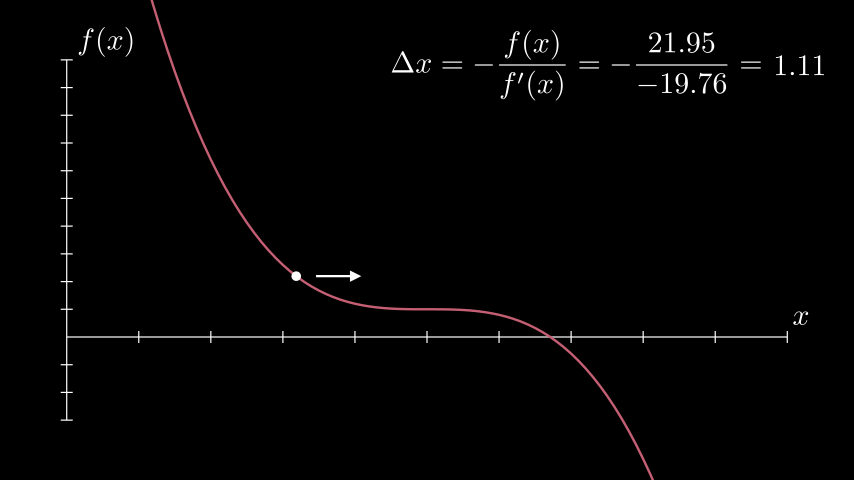

In [66]:
display(MD(
r"""## Not limited to rendering videos

Additionnally, Manim can render images (e.g., see <a href="/#0">first slide</a>) or gif.
"""
))

%manim --format=png -n 0,4 -s RootExample

## Then, what's next?

Create more advanced animation, and get inspiration from others, see:

* [Made with Manim](https://www.manim.community/awesome/), a collection of content creators utilizing the power of Manim
* [Reducible](https://www.youtube.com/c/Reducible), a YouTuber that utilizes Manim for its videos <br>![YouTube Channel Subscribers](https://img.shields.io/youtube/channel/subscribers/UCK8XIGR5kRidIw2fWqwyHRA?style=social)
* the Manim subreddit for questions and inspirations <br><a href="https://www.reddit.com/r/manim/"><img src="https://img.shields.io/reddit/subreddit-subscribers/manim?style=social" alt="Manim Subreddit"></a>
* the Manim Community discord for questions and inspirations <br><a href="https://www.manim.community/discord/"><img src="https://img.shields.io/discord/581738731934056449.svg?label=discord&color=yellow&logo=discord" alt="Discord"></a>


## When to use Manim?

"*Is Manim for everyone?*"
* Yes, we think most students and professors can benefit from using Manim

"*Is Manim for every presentation?*"
* No, Manim is best used when animation make things clearer to the audience

"*What should I be aware of?*"
* Creating animations can take a lot of time...

"*When is Manim particularly useful?*"
* In small conference talks (~ 10 min.), educational videos, blog posts...

# 4. Various plugins

## Manim Plugins

Many plugins were created by users, some of which can be found on https://plugins.manim.community/.

we particularly like:

* [Manim Physics](https://github.com/Matheart/manim-physics), a physics simulation plugin for Manim
* [Chanim](https://github.com/kilacoda/chanim), an animation engine for explanatory chemistry videos
* [ManimML](https://github.com/manimml/ManimML), a project focusing on visualizations of Machine Learning concepts
* [Manim Automata](https://github.com/SeanNelsonIO/manim-automata), to render Finite State Machines
* [Manim GearBox](https://github.com/GarryBGoode/manim-GearBox), to animate gearboxes

## Using Manim inside Jupyter

This presentation uses Manim inside Jupyter Notebook cells.

```python
%%manim SquareToCircle


class SquareToCircle(Scene):
    def construct(self):
        circle = Circle(color=RED)
        square = Square()

        self.play(Create(square))
        self.play(Transform(square, circle))
        self.play(FadeOut(square))
```

## Interactive presentation with Manim Slides

Remember root finding example from earlier?

*What if* we could pause the video whenever we want? Go backward, forward, reverse, and so on?

```python
from manim import *


class RootExample(Scene):
    def construct(self):
        # Not shown:
        #   Constructing axes, labels, graph, dots, etc.
        #   and make sure they update on every frame

        self.add(ax, labels, graph, dot)  # Add plot to scene
        self.play(Write(fraction))  # Animation fraction writing

        self.wait()  # Wait for some time

        while abs(f(x)) > 1e-6:  # Until convergence
            dx = -f(x) / df(x)
            x += dx
            
            # Not shown:
            #  Computing new destination, and creating horizontal arrow

            self.play(Create(direction))  # Animate arrow creation
            self.play(...) # Animation dot's displacement and arrow's fading

        self.wait(5)  # Wait for some time
```

<code style="background-color:white">
  from manim import *
<span style="color:green">+ from manim_slides import Slide</span>

<span style="color:red">- class RootExample(Scene):</span>
<span style="color:green">+ class RootExample(Slide):</span>
        ...
              ...   
              self.play(Write(fraction))
              self.add(ax, labels, graph, dot)
              self.wait()
<span style="color:green">+             self.pause()</span>
              self.play(Write(fraction))
<span style="color:green">+             self.pause()</span>
          
               while abs(f(x)) > 1e-6:         
                  ...
                  self.play(Create(direction))
                  self.play(AnimationGroup(t.animate.set_value(x), FadeOut(direction)))
<span style="color:green">+                self.pause()</span>
</code>

### Demo time!

# Thank you for listening!

<br>
<br>

<table>
    <tr style="background-color: #fff;">
        <th><center>GitHub repository</center></th>
        <th>&nbsp;&nbsp;&nbsp;&nbsp;</th>
        <th><center>Presentation slides online</center></th>
    </tr>
    <tr style="background-color: #fff;">
        <td><center><img width="200px" src="images/github-qrcode.png"></center></td>
        <td></td>
        <td><center><img width="200px" src="images/slides-qrcode.png"></center></td>
    </tr>
    <tr style="background-color: #fff;">
        <td><center><a href="https://github.com/jeertmans/manim-tutorial">https://github.com/jeertmans/manim-tutorial</a></center></td>
        <td></td>
        <td><center><a href="https://eertmans.be/manim-tutorial">https://eertmans.be/manim-tutorial</a></center></td>
    </tr>
</table>